In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind
from scipy.stats import spearmanr

from selenium import webdriver

import time
import re

import csv

from datetime import datetime, timedelta

# Starcraft 2 Gold Base

## How does mining minerals translate to real life?

### Abstract

In this article I am exploring the economy of competitive Starcraft 2 e-Sports scene backed by data for player base and tournament earnings.

I specifically focus on the presense of Korean players forging the highs and lows of the industry. 

### Introduction

Let me preface with the the term [Gold base](https://liquipedia.net/starcraft2/Resources#Rich_Mineral_Fields). In the game itself it is a stack of _rich minerals_ which yield greater resources than normal _mineral fields_. Another characteristic is that it has less batches and due to the faster mining it provides resources faster but also depletes quicker.

During my exploration I constructed an analogy of gathering resources in-game and the South Korea's perseverence in Starcraft 2's e-Sports scene. 

I took inspiration from another data analysis by [pstragowskipiotr](https://github.com/pstragowskipiotr/Starcraft-e-Sport-analysis) [\[1\]](#References) and had an independent look at the data.

In this notebook I detailed data acquisition, cleaning, data visualisation and analysis.

### Data acquisition

There are numerous websites displaying rankings of players and earnings some of which provide public access to all their collected data. One of them is [Aligulac](http://aligulac.com/) [\[2\]](#References). It provides a regularly updated database datadump. It provides a good range of professional online and offline matches and players across the globe.

The acquisition process itself was a challenge but a good experience. These are the steps I went though:
* installation of PostgreSQL and creating CSV files.
* scraping a website for additional data
* NULL value cleanup and of cource more changes during EDA (Exploratory Data Analysis)

#### Database data retrieval

Let us take a look at the [Database description](http://aligulac.com/about/db/).

As mentioned earlier I would want to to extract CSV files for convenience and to have all my data for offline usage without require a DB server going forwards. The datadump is an SQL query created on PostgreSQL so first thing would be to install it:

https://www.postgresql.org/

From here on I can open up a DB server and create and extract your tables, but isntalling a client might such as pgAdmin would help quite a bit:

https://www.pgadmin.org/download/

I can now setup a server with pgAdmin then in the command execute the sql query to populate my database:
```cmd
psql -U postgres -h localhost -d my_database -f "path\to\aligulac.sql"
```

The last thing would be to extract them to csv files by opening the Query Tool in pgAdmin and execute:
```sql
COPY table_name to 'path/to/output/file.csv' csv header;
```

The tables I am interested in are:
* earnings
* event
* match
* player

I would put these files in a folder for cleanliness. As I already did that you can find all of them in the data folder. 

#### Player dataset exploration

Now that we have the csv files, let's explore the player dataset.

In [3]:
player_data = pd.read_csv("data/player.csv", index_col = "id")

In [4]:
player_data.head()

,tag,name,birthday,mcnum,tlpd_id,tlpd_db,lp_name,sc2e_id,country,race,dom_val,dom_start_id,dom_end_id,current_rating_id,romanized_name
id,,,,,,,,,,,,,,,
21622,나코나코땅땅,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KR,P,-1.771827,25.0,26.0,7303345.0,NaN
21609,Alexey,NaN,NaN,NaN,NaN,NaN,NaN,NaN,UA,T,-1.977932,25.0,26.0,7303326.0,NaN
21610,Bush,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LT,P,-1.956826,25.0,26.0,7303327.0,NaN
21615,Chenne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CA,P,-1.969522,25.0,26.0,7303346.0,NaN
21608,depulsor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,DE,Z,-1.929563,25.0,26.0,7303328.0,NaN


In [5]:
player_data.dtypes

tag                   object
name                  object
birthday              object
mcnum                float64
tlpd_id              float64
tlpd_db              float64
lp_name               object
sc2e_id              float64
country               object
race                  object
dom_val              float64
dom_start_id         float64
dom_end_id           float64
current_rating_id    float64
romanized_name        object
dtype: object

There are few columns names we are immediately interested in: id, tag, birthday, country and maybe (in-game) race. We are also interested in "tlpd_id" reasoned later in the exploration process. We really want to convert all id type columns to integers for associating with other datasets.

In [6]:
player_data.tlpd_id = player_data.tlpd_id.fillna(-1)
player_data.tlpd_id = player_data.tlpd_id.astype(int)

In [7]:
top_player_count_by_nationality = player_data.groupby("country").size().nlargest(10).sort_values()

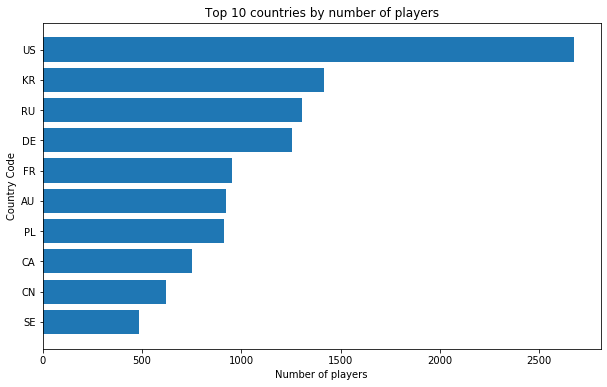

In [8]:
plt.figure(figsize = (10, 6))

plt.barh(top_player_count_by_nationality.index, top_player_count_by_nationality)

plt.xlabel("Number of players")
plt.ylabel("Country Code")
plt.title("Top 10 countries by number of players")
plt.show()

Interestingly enough this database is a bit biased towards having more players of the United States, but it would not affect my research much as we can see later.

There is a preconceived notion that there are a lot ot Korean players at a professional level since they win a lot, but that does not seem to be the case. Although South Korea is still in second place we can further extrapolate on why they seem to dominate and if it holds true through the entire lifespan of Starcraft 2 so far.

In fact, I will be a little bit ahead of myself and add a column indicating if the player is korean or not. It would help help immensely for further groupings.

In [9]:
player_data["sc_nationality"] = player_data.apply(lambda row: "South Korea" if row.country == "KR" else "The World", axis=1)

#### Earnings dataset exploration

In [10]:
earning_data = pd.read_csv("data/earnings.csv", index_col = "id")

earning_data.head(5)

,event_id,player_id,earnings,origearnings,currency,placement
id,,,,,,
1,11922,28,12500.0,12500.0,USD,1
2,11922,18,6250.0,6250.0,USD,2
3,11922,22,3750.0,3750.0,USD,3
4,11922,106,2500.0,2500.0,USD,4
5,11921,3,12500.0,12500.0,USD,1


In [11]:
any_earning_filter = earning_data.earnings >= 0
any_origearning_filter = earning_data.origearnings >= 0
non_earnings = earning_data[~any_earning_filter]
non_origearnings = earning_data[~any_origearning_filter]

assert len(earning_data[~any_origearning_filter]) == 0

print("There are %d prize money records that are not converted to USD or none." % len(non_earnings))
non_earnings

There are 17 prize money records that are not converted to USD or none.


,event_id,player_id,earnings,origearnings,currency,placement
id,,,,,,
12956,13283,119,NaN,350.0,AUD,1
12957,13283,882,NaN,100.0,AUD,2
13510,27239,5280,NaN,50.0,BRL,1
14242,30457,117,NaN,25.0,EUR,1
14243,30457,2573,NaN,75.0,EUR,2
16371,36335,1276,NaN,5000.0,JPY,1
16372,36335,2336,NaN,3000.0,JPY,2
16373,36335,5447,NaN,1000.0,JPY,3
16374,36337,2361,NaN,5000.0,JPY,1


Upon checking out invalid earnings, we can see that currency in involved. Taking a look at the table description again, earnings column is prize money in USD. So I normalized all earnings to USD.

In [12]:
non_converted_currencies = non_earnings.currency.unique()
print("We only care about conversion of %s currencies." % ", ".join(non_converted_currencies))

We only care about conversion of AUD, BRL, EUR, JPY, CNY currencies.


In [13]:
rates_to_usd = dict(zip(non_converted_currencies, [1] * len(non_converted_currencies)))

for currency in rates_to_usd.keys():
    row = earning_data[(earning_data.currency == currency) & any_earning_filter & any_earning_filter].head(1).iloc[0]
    rates_to_usd[currency] = row.earnings / row.origearnings

earning_data.loc[~any_earning_filter, "earnings"] =\
    earning_data[~any_earning_filter].apply(lambda row: round(row.origearnings * rates_to_usd[row.currency], 1), axis=1)

try:
    assert len(earning_data[~(earning_data.earnings >= 0)]) == 0
    print("All earnings are converted.")
except:
    print("There are still unconverted earnings")

All earnings are converted.


In [14]:
try:
    assert len(earning_data[earning_data["event_id"].isnull()]) == 0
    print("All earnings are associated with an event.")
except:
    print("Some earnings are not associated with an event.")

All earnings are associated with an event.


#### Event dataset exploration

This dataset helps us determine the date of prize winnings, as each is associated with a tournament. We can consider the end of the tournament to be the date of earning.

In [15]:
event_data = pd.read_csv("data/event.csv", index_col = "id")

event_data.parent_id = event_data.parent_id.fillna(-1)
event_data.parent_id = event_data.parent_id.astype(int)

event_data.head(5)

,name,parent_id,lft,rgt,closed,big,noprint,fullname,homepage,lp_name,...,tlpd_db,tl_thread,prizepool,earliest,latest,category,type,idx,wcs_year,wcs_tier
id,,,,,,,,,,,,,,,,,,,,,
112911,Ro128,112896,NaN,NaN,f,f,f,ESL Open Cup Americas #31 Ro128,NaN,NaN,...,NaN,NaN,NaN,2020-08-10,2020-08-10,NaN,round,25419,NaN,NaN
112922,Qualifier,112920,NaN,NaN,f,f,f,SC2Online Super Series 2020 Mid Season #2 Qual...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,round,81516,NaN,NaN
112919,#9,111789,NaN,NaN,f,f,f,Winner Winner I'll Buy You Dinner #9,NaN,NaN,...,NaN,NaN,t,2020-08-01,2020-08-01,NaN,event,105739,NaN,NaN
112921,Main Event,112920,NaN,NaN,f,f,f,SC2Online Super Series 2020 Mid Season #2 Main...,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,round,81515,NaN,NaN
112918,#8,111789,NaN,NaN,f,f,f,Winner Winner I'll Buy You Dinner #8,NaN,NaN,...,NaN,NaN,t,2020-07-25,2020-07-25,NaN,event,105738,NaN,NaN


In [16]:
earnings_data_full = \
    earning_data.merge(player_data, left_on = "player_id", right_index = True, how = "inner")\
                .merge(event_data, left_on = "event_id", right_index = True, how = "inner")

earnings_data_full = earnings_data_full.rename({"latest": "date"}, axis = 1).drop("earliest", axis = 1)

In [17]:
earnings_with_no_date = earnings_data_full[earnings_data_full.date.isnull()]
print("There are %d earnings without dates." % len(earnings_with_no_date))

There are 59 earnings without dates.


It seems like there are some events with no dates. We can get those from their ancestors' events.

In [18]:
earnings_data_full.loc[earnings_data_full.date.isnull(), ["date"]] =\
    earnings_data_full[earnings_data_full.date.isnull()]\
        .apply(lambda row: event_data.iloc[row.parent_id]["latest"] if row.parent_id >= 0 else None, axis=1)

In [19]:
print("It seem like event(s) with id %s do not have date(s), neither do their parent event(s)." %\
          ", ".join(earnings_data_full[earnings_data_full.date.isnull()].event_id.astype(str).unique()))

It seem like event(s) with id 50618, 74194 do not have date(s), neither do their parent event(s).


We can look them up in the internet and add them manually.

In [20]:
event_data[event_data.index.isin([50618, 74194])][["fullname"]]

,fullname
id,
74194,Master's Coliseum 2
50618,Vectorama 2012


In [21]:
earnings_data_full.at[earnings_data_full.event_id == 74194, "date"] = "2017-10-13"
earnings_data_full.at[earnings_data_full.event_id == 50618, "date"] = "2012-06-09"

In [22]:
try:
    assert len(earnings_data_full[earnings_data_full.date.isnull()]) == 0
    print("All earnings have dates.")
except:
    print("Some earnings still do not have dates.")

All earnings have dates.


In [23]:
earnings_data_full.date = pd.to_datetime(earnings_data_full.date)

As previously denoted I want to see why South Korea is conceived as the undisputed best nation when it comes to Starcraft 2. The simplest indicators would be to first checkout number of championship in major tournaments and prize earnings over the years.

### Tournaments Domination

Funnily, the event dataset does not provide information for player placement but rather the earnings table. I can reuse the fully joined ```earnings_data_full``` dataframe.

In [24]:
def simple_plot(
    grouped_data,
    reverse = False,
    plot = plt,
    plot_type = "bar",
    horizontal = False,
    title = None,
    xlabel = None,
    ylabel = None,
    fontsize = None,
    show_percentage = False,
    show = True):
    title_fontsize = None
    label_fontsize = None
    if fontsize is not None:
        title_fontsize = fontsize
        label_fontsize = 0.8 * fontsize
    
    if reverse:
        grouped_data = grouped_data[::-1]
    
    if plot == plt:
        plt.figure(figsize = (10, 6))

    if (plot_type == "bar") and horizontal:
        plot.barh(grouped_data.index, grouped_data)
    elif (plot_type == "bar"):
        plot.bar(grouped_data.index, grouped_data)
    elif (plot_type == "pie"):
        colors = ['#ff9999','#66b3ff']
        pct = None

        if show_percentage:
            pct = lambda x: '{:.2f}%\n({:.0f})'.format(x, sum(grouped_data) * x / 100)
        plot.pie(grouped_data,
                 labels = grouped_data.index,
                 startangle=90,
                 colors = colors,
                 autopct = pct,
                 textprops = {'fontsize': label_fontsize})
    else:
        raise ValueError("The plot type must be either \"bar\" or \"pie\"")

        
    if plot == plt:
        plot.title(title, size = title_fontsize)
        plot.xlabel(xlabel, fontsize = label_fontsize)
        plot.ylabel(ylabel, fontsize = label_fontsize)
    else:
        plot.set_title(title, size = title_fontsize)
        plot.set_xlabel(xlabel, fontsize = label_fontsize)
        plot.set_ylabel(ylabel, fontsize = label_fontsize)

    if show:
        plt.show()

In [25]:
highest_number_championships_by_country =\
    earnings_data_full[(earnings_data_full.placement == 1)]\
    .groupby("country").size()\
    .nlargest(10).sort_values()

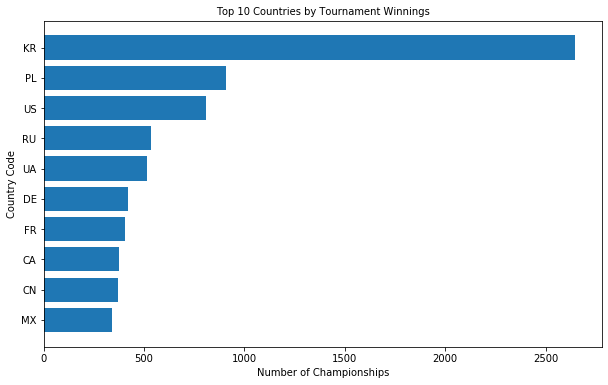

In [26]:
simple_plot(
    highest_number_championships_by_country,
    horizontal = True,
    title = "Top 10 Countries by Tournament Winnings",
    xlabel = "Number of Championships",
    ylabel = "Country Code")

South Korea is the winningest country by a big margin compared to next the best country, so it is suitable to compare them to the rest of the world as a whole unit. This consideration will also hold true going forwards as the data will be more comparable, proping the ```sc_nationality``` column.

In Esports prize money is not the best indication for a players income, there are more factors such as endorsements, advertisements, sponsors and salary, as well as other side works such as youtube or streaming. But in the true sense of competition, tournaments with the biggest prize pool hold the most value and brings about the best drive from the players.

In [27]:
all_championships_number_by_country =\
    earnings_data_full[(earnings_data_full.placement == 1)]\
    .groupby("sc_nationality").size()
significant_championships_number_by_country =\
    earnings_data_full[(earnings_data_full.placement == 1) & (earnings_data_full.earnings > 1000)]\
    .groupby("sc_nationality").size()
very_significant_championships_number_by_country =\
    earnings_data_full[(earnings_data_full.placement == 1) & (earnings_data_full.earnings > 10000)]\
    .groupby("sc_nationality").size()

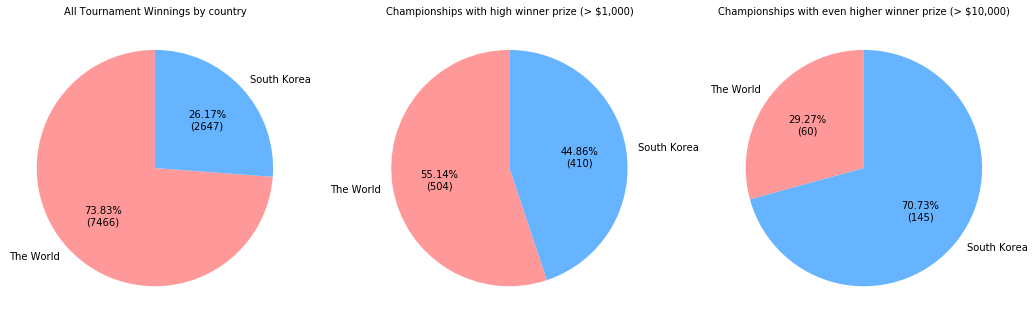

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True)
fig.set_size_inches((18, 9))

simple_plot(
    all_championships_number_by_country,
    reverse = True,
    title = "All Tournament Winnings by country",
    plot = ax1,
    plot_type = "pie",
    show_percentage = True,
    show = False)
simple_plot(
    significant_championships_number_by_country,
    reverse = True,
    title = "Championships with high winner prize (> $1,000)",
    plot = ax2,
    plot_type = "pie",
    show_percentage = True,
    show = False)
simple_plot(
    very_significant_championships_number_by_country,
    reverse = True,
    title = "Championships with even higher winner prize (> $10,000)",
    plot = ax3,
    plot_type = "pie",
    show_percentage = True,
    show = False)

plt.show()

In [29]:
player_earnings_data = earnings_data_full\
    .groupby("player_id").agg({"earnings": "sum"})\
    .merge(player_data, left_index = True, right_index = True, how = "inner")

num_players_with_earnings_by_country = player_earnings_data.groupby("sc_nationality").size()

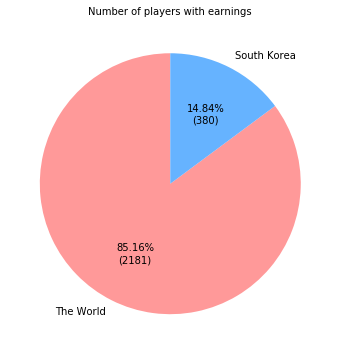

In [30]:
simple_plot(
    num_players_with_earnings_by_country,
    reverse = True,
    title = "Number of players with earnings",
    plot = plt,
    plot_type = "pie",
    show_percentage = True,
    show = True)

As seen on the charts South Korean players represent 15% of the player base with any prize money from tournament. But the higher the stake, the greater the number of Korean players there is compared to the rest of the world. This is where the term "Foreign player" comes from, denoting players not originating from South Korea. Their position in a match againt a Korean player is always of the underdog.

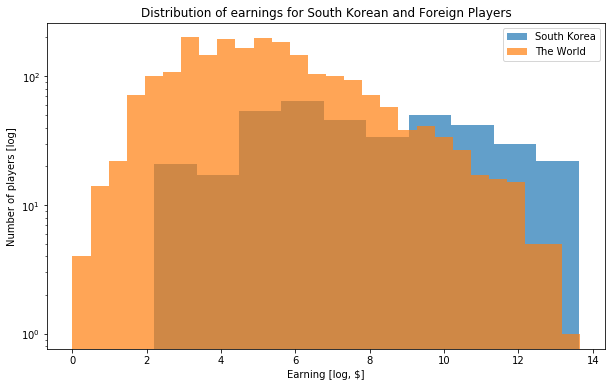

In [31]:
korean_filter = player_earnings_data.sc_nationality == "South Korea"
korean_earnings = player_earnings_data.earnings[korean_filter]
non_korean_earnings = player_earnings_data.earnings[~korean_filter]

plt.figure(figsize = (10, 6))

plt.hist(np.log(korean_earnings), label = "South Korea", log = True, bins = "fd", alpha = 0.7)
plt.hist(np.log(non_korean_earnings), label = "The World", log = True, bins = "fd", alpha = 0.7)

plt.title("Distribution of earnings for South Korean and Foreign Players")
plt.xlabel("Earning [log, $]")
plt.ylabel("Number of players [log]")

plt.legend()
plt.show()

Although I see that the distributions seem very different, I would like to run a *null hypothesis* t-test to denounce that they are of the same distribution, setting myself a threshold of 1%.

As I have observed korean and non-korean players do not have similar count, so I can run the following:

In [32]:
ttest_ind(korean_earnings, non_korean_earnings, equal_var = False).pvalue

3.965799981375449e-11

With a p-score of $3.9^{-9}\%$ I can move on.

### Economics of a Nation

In [33]:
def group_earnings(earnings_data, by = "year", ):
    grouped_data = None
    
    if by in ["day", "month", "year"]:
        grouped_data = earnings_data.groupby(getattr(earnings_data["date"].dt, by)).agg({"earnings": "sum"})
    elif by in earnings_data.columns.tolist():
        grouped_data = earnings_data.groupby(by).agg({"earnings": "sum"})
    
    return grouped_data

In [34]:
all_earnings_by_year = group_earnings(earnings_data_full, by = "year")
kr_earnings_by_year = group_earnings(earnings_data_full[earnings_data_full.country == "KR"], by = "year")
non_kr_earnings_by_year = group_earnings(earnings_data_full[earnings_data_full.country != "KR"], by = "year")

kr_earnings_by_player = group_earnings(earnings_data_full[earnings_data_full.country == "KR"], by = "player_id")

In [35]:
def plot_earnings_by_year(earnings_by_year, title = None, legend_label = None, show = True):
    plt.figure(figsize = (10, 6))

    plt.bar(earnings_by_year.index, earnings_by_year.earnings, label = legend_label)
    
    x = np.arange(np.min(earnings_by_year.index), np.max(earnings_by_year.index) + 1)
    xlabels = x.astype(str)
    xlabels[0] = xlabels[0] + "\nJuly"
    xlabels[-1] = xlabels[-1] + "\nAugust"
    
    plt.xticks(x, labels = xlabels)
    plt.yticks(plt.yticks()[0], ["{:,}".format(int(x)) for x in plt.yticks()[0].tolist()])
    
    if title:
        plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Earnings [$]")
    if legend_label:
        plt.legend()
    if show:
        plt.show()

In [36]:
def plot_earnings_grouped_bars_by_year(
    groups,
    title = None,
    legend_labels = None,
    show = True):
    min_year = np.min([np.min(group.index) for group in groups])
    max_year = np.max([np.max(group.index) for group in groups])

    x = np.arange(min_year, max_year + 1)
    xlabels = x.astype('str')
    xlabels[0] = xlabels[0] + "\nJuly"
    xlabels[-1] = xlabels[-1] + "\nAugust"
    
    bar_width = 1 / (len(groups) + 1)
    group_positions = []
    
    fig, ax = plt.subplots()
    fig.set_size_inches((10, 6))
    
    for index in range(len(groups)):
        group_positions = x - 0.5 + bar_width + index * bar_width
        legend_label = legend_labels[index] if (legend_labels is not None) and (len(legend_labels) > index) else None
        ax.bar(group_positions, groups[index].earnings, bar_width, label = legend_label)

    ax.set_xticks(x)
    ax.set_xticklabels(xlabels)
    ax.set_xlim((min_year - 2 * bar_width, max_year + 2 * bar_width))
    ax.set_yticklabels(["{:,}".format(int(x)) for x in ax.get_yticks().tolist()])

    if title:
        plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Earnings [$]")
    if legend_labels:
        plt.legend()
    if show:
        plt.show()

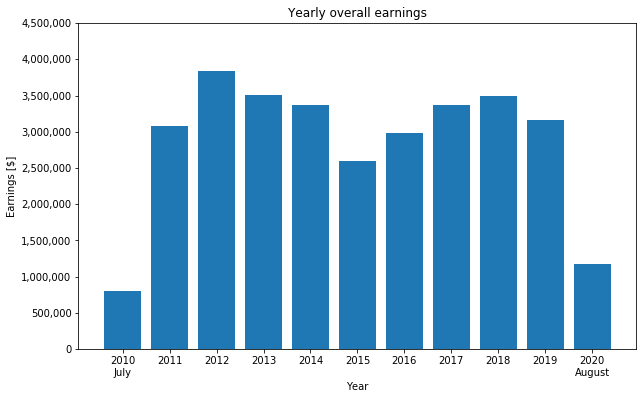

In [37]:
plot_earnings_by_year(all_earnings_by_year, title = "Yearly overall earnings")

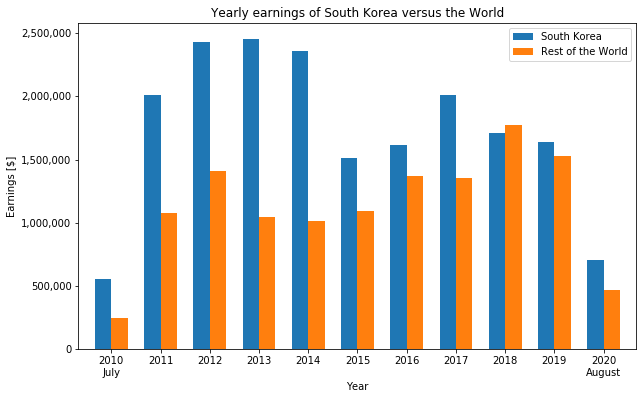

In [38]:
plot_earnings_grouped_bars_by_year(
    [kr_earnings_by_year, non_kr_earnings_by_year],
    title = "Yearly earnings of South Korea versus the World",
    legend_labels = ["South Korea", "Rest of the World"])

Starcraft 2 was released on July 27, 2010 and has received tremendous attention from the get go. Its e-Sports scene directly succeeds Starcraft Broodwar scene which was on its 12 year anniversary.

Back in the day WCG was the biggest non-regional event where player from within and outside South Korean could compete directly. Having [all of them won by South Korea](https://liquipedia.net/starcraft/World_Cyber_Games#WCG_StarCraft:_BroodWar_Winners) and the fact that [the biggest leagues](https://liquipedia.net/starcraft/Leagues) are based in the country, we can claim that South Korea is the mecca of Starcraft e-Sports. But for a technology driven media such as video games a 12-year run eventually comes to a decline.

With the fresh content and Broodwar players moving to a new game as well as an even playing field for the Foreign players Starcraft 2 brings about a good start. The rise of gaming streaming services such as Own3D and Justin.tv (later bacoming [Twitch](https://en.wikipedia.org/wiki/Twitch_\(service\))) marks a great boost to the viewership and sponsorship to tournaments.

Although the scene had a big jump for first 2 years of its exitence, over the next 3 years it started declining due to South Korean domination and the rise of other biggest e-Sports scene for League of Legends. It's biggest hit was in 2015 where another big game [Overwatch](https://killscreen.com/themeta/pc-bangs-seoul-overwatch-reigns-supreme/)  [\[3\]](#References) hit the shelves and the infamous [match-fixing scandal](https://liquipedia.net/starcraft2/2015_Match-Fixing_Scandal) amidst a declining viewertship cemented the worst year since existence. Fortunately it was not a fatal blow as what happened in the [Broodwar](https://liquipedia.net/starcraft/Match_Fixing_Scandal) days.

With the release of the games [latest expansion](https://en.wikipedia.org/wiki/StarCraft_II:_Legacy_of_the_Void) in 2015 hit another growth spurt. But this time it is a bit different.

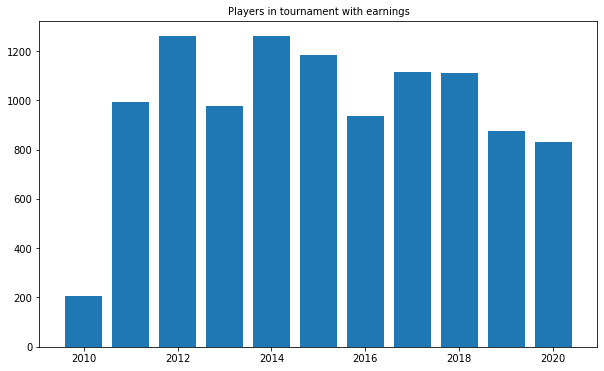

In [39]:
korean_players_earnings_by_year =\
    earnings_data_full[earnings_data_full.sc_nationality == "South Korea"]\
    .groupby(earnings_data_full["date"].dt.year).size()

simple_plot(korean_players_earnings_by_year, title = "Players in tournament with earnings")

See, over the years the total prize earnings from Korean players have consistently been higher than the rest of the world with the exception of 2018 but that exception comes from the a trend over the years. The gap in earnings has decreased gradually although the Korean players presense decline is not that steep.

The 2020 COVID-19 pandemic was also not favorable to the industry. Two third of the year has passed but the prizepool is less than half compared to the previuous year.

### Most Valuable Players

In this section I would like to explore individual performances driving the cumulative data. 

In [40]:
num_players = len(player_data)
num_players_without_birthday = len(player_data[player_data.birthday.isnull()])

print("%d of out %d (%s) do not have birthday records" % \
      (num_players_without_birthday,
       num_players,
       "{:.1%}".format(num_players_without_birthday / num_players)))

18747 of out 19503 (96.1%) do not have birthday records


That is quite a big chunk of missing data, but we do not really need to retrieve all of them.
Taking a look at earnings we can see only a fraction of all recorded players have received prize money from tournaments. Let us take a look at the table first.

In [41]:
players_with_earnings = earnings_data_full.groupby("player_id").agg({"earnings": "sum", "date": ["min", "max"]})
players_with_earnings.columns = ['_'.join(col).strip() for col in players_with_earnings.columns.values]
players_with_earnings = players_with_earnings.merge(player_data, left_index = True, right_on = "id", how = "inner")
players_with_earnings =\
    players_with_earnings[["tag", "tlpd_id", "birthday", "sc_nationality", "race", "date_min", "date_max", "earnings_sum"]]\
    .rename({"earnings_sum": "earnings", "date_min": "earnings_min_date", "date_max": "earnings_max_date"}, axis = 1)

In [42]:
players_with_earnings.head()

,tag,tlpd_id,birthday,sc_nationality,race,earnings_min_date,earnings_max_date,earnings
id,,,,,,,,
1,Leenock,1971,1995-04-01,South Korea,Z,2010-11-13,2019-06-22,275579.0
2,Creator,2838,1997-02-23,South Korea,P,2011-05-06,2020-08-04,123741.0
3,Life,2747,1997-01-11,South Korea,Z,2011-07-06,2016-02-05,470559.0
4,DongRaeGu,2627,1991-06-03,South Korea,Z,2011-06-18,2020-08-11,258874.0
5,PartinG,2322,1994-08-24,South Korea,P,2011-12-07,2020-08-10,400282.0


In [43]:
players_without_birthday = players_with_earnings[players_with_earnings.birthday.isnull()]
print("There are %d out of %d (%s) players without birthday." % \
    (len(players_without_birthday),
     len(players_with_earnings),
     "{:.1%}".format(len(players_without_birthday) / len(players_with_earnings))))

There are 1934 out of 2561 (75.5%) players without birthday.


In [44]:
players_without_birthday

,tag,tlpd_id,birthday,sc_nationality,race,earnings_min_date,earnings_max_date,earnings
id,,,,,,,,
64,Sting,3817,NaN,South Korea,T,2011-11-02,2016-06-18,15539.0
78,monchi,2796,NaN,The World,P,2011-07-19,2013-05-26,20017.0
84,TREME,3601,NaN,South Korea,P,2011-08-29,2012-07-25,584.0
130,roof,3263,NaN,The World,Z,2011-07-17,2015-01-27,2206.0
135,ReaL,4079,NaN,South Korea,P,2011-09-27,2013-01-05,5402.0
...,...,...,...,...,...,...,...,...
21077,Noah,-1,NaN,The World,Z,2020-07-11,2020-07-11,10.0
21080,Mataaaaaa,-1,NaN,The World,P,2020-06-13,2020-06-13,10.0
21174,Teebo,-1,NaN,The World,P,2020-06-28,2020-06-28,100.0


Seeing that the percentage of players with birthday among those with earnings is much higher to those among all players (24.5% to 3.9%), we can say that the players with earnings are already "more interesting" from the get go.

Now I will finish things up by populating the birthdays as much as possible and see if we can make another observation.

One place with comprensive data for Starcraft 2 players is [tl.net](https://tl.net). Recently the website seized its API from public usage, but its search functionality in still intact. I am somewhat bound to rely on scraping and that's what I will do.

The scraping itself is quite tedious as I have to load a page for individual player and scrape the birthday out of the page source. Doing to for 1934 players each for 5-10 seconds depending on good internet connection and CPU, it would take about 30 minutes. I did that beforehand into 'data/birthday.csv' file.

Please checkout the provided code in _scrape.py_ file in *tools* folder. Make sure to install selenium as as our scraping tool:

```cmd
conda install -c conda-forge selenium
```

For some reason exporting the code outside the notebook gave unreliable results even with explicit wait, so I am leaving the code here for you to execute if you want. 

In [45]:
def scrape_sc2_international(driver, player_tlpd_id):
    driver.get("https://tl.net/tlpd/sc2-international/players/" + str(player_tlpd_id))
    birthday = None

    try:
        el = driver.find_element_by_xpath("//div[@id='main-container']/div[@id='main-content']/div[@class='roundcont']/p[4]")
        text = el.get_attribute("innerText")
        text_split = re.split('(\d{4}-\d{2}-\d{2})', text, 1)
        birthday = text_split[1]
    except Exception as e:
        # print("ERROR: Cound not find birthday for " + player_tlpd_id)
        pass

    return birthday

def scrape_liquipedia(driver, player_tag):
    driver.get("https://liquipedia.net/starcraft2/" + player_tag)
    birthday = None

    try:
        el = driver.find_element_by_xpath('//span[@class="bday"]')
        birthday = el.get_attribute("innerText")
    except Exception as e:
        # print("ERROR: Cound not find birthday for " + player_id)
        pass

    return birthday

def scrape_birthdays(player_dataframe):
    birthday_list = []

    start_time = time.time()
    driver = webdriver.Chrome("tools/chromedriver.exe")

    try:
        for index, player in player_dataframe.iterrows():
            birthday = None

            if player.tlpd_id > -1:
                birthday = scrape_sc2_international(driver, player.tlpd_id)

            if birthday is None:
                birthday = scrape_liquipedia(driver, player.tag)

            birthday_list.append({ "player_id": index, "tlpd_id": player.tlpd_id, "birthday": birthday })
    except Exception as e:
        print("ERROR: ", e)

    driver.close()
    print("Finished scraping in %d", time.time() - start_time)
    
    return birthday_list

def exctract_birthday_csv(player_dataframe, filename):
    birthday_list = scrape_birthdays(player_dataframe)

    csv_columns = ["player_id", "tlpd_id", "birthday"]
    csv_file = filename

    try:
        with open(csv_file, 'w') as csvfile:
            writer = csv.DictWriter(csvfile, fieldnames = csv_columns)
            writer.writeheader()
            for data in birthday_list:
                writer.writerow(data)
    except IOError:
        print("I/O error")

In [46]:
# Feel free to uncomment to execute
# exctract_birthday_csv(players_without_birthday, filename = "data/birthday.csv")

In [47]:
birthday_data = pd.read_csv("data/birthday.csv", index_col = "player_id")

In [48]:
birthday_data.head()

,tlpd_id,birthday
player_id,,
64,3817,NaN
78,2796,NaN
84,3601,NaN
130,3263,NaN
135,4079,NaN


In [49]:
num_birthday_data_from_csv = len(birthday_data[~birthday_data.birthday.isnull()])
print("There are %d (%s) scraped birthdays." %
         (num_birthday_data_from_csv,
          "{:.1%}".format(num_birthday_data_from_csv / len(birthday_data))))

There are 314 (16.2%) scraped birthdays.


Unfortunatly, not that many birthdays were recovered but will be good enough to boost the records of player with earnings and birthday.

In [50]:
num_birthday_data_from_csv = len(birthday_data[~birthday_data.birthday.isnull()])
num_players_before_update = len(players_with_earnings[~players_with_earnings.birthday.isnull()])

players_with_earnings.update(birthday_data, overwrite = False)

num_players_after_update = len(players_with_earnings[~players_with_earnings.birthday.isnull()])

try:
    assert num_players_after_update == num_birthday_data_from_csv + num_players_before_update
    print("Update birthdays successful.\n===============")
except:
    print("Update error. %d != %d + %d\n===============" %\
          (num_players_after_update, num_birthday_data_from_csv, num_players_before_update))

print("There is a total of %d players with earnings and birthday." % len(players_with_earnings[~players_with_earnings.birthday.isnull()]))

Update birthdays successful.
There is a total of 941 players with earnings and birthday.


In [51]:
players_with_earnings.birthday = pd.to_datetime(players_with_earnings.birthday)

In [52]:
now = datetime.now()
players_with_earnings["age"] = players_with_earnings.birthday.apply(
    lambda row_birthday: None if row_birthday is None else (now - row_birthday).days/(366))

In [53]:
color_palette = ['#ff9999','#66b3ff']

def plot_scatter_earnings(sc_data, byattribute, title = "", xlabel = "", show = True):
    color_palette = ['#ff9999','#66b3ff']
    
    kr_earnings = sc_data[sc_data.sc_nationality == "South Korea"]
    non_kr_earnings = sc_data[~(sc_data.sc_nationality == "South Korea")]
    
    plt.scatter(kr_earnings[byattribute], kr_earnings.earnings, c = color_palette[1], label = "Korean")
    plt.scatter(non_kr_earnings[byattribute], non_kr_earnings.earnings, c = color_palette[0], label = "Foreigner")

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Earnings [$]")
    
    if show:
        plt.show()

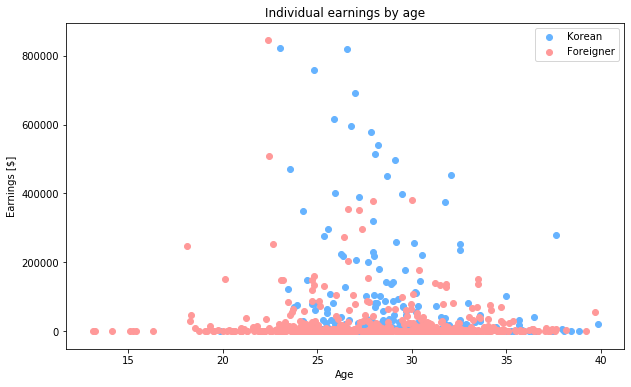

In [54]:
plt.figure(figsize = (10, 6))
plot_scatter_earnings(players_with_earnings, "age", title = "Individual earnings by age", xlabel = "Age", show = False)
plt.legend()
plt.show()

What I can see at this moment, is that there are a there is a big clutter in the lower section across all ages and the highest earners are from the 22-32 age bracket.

This plot does not help me a lot to analyse because prize money are earned over years and some already of these players are already retired. That is what I did by retrieving the latest and earliest match from the ```match``` dataset.

In [55]:
match_data = pd.read_csv("data/match.csv", index_col = "id")
match_data.head()

,period_id,date,pla_id,plb_id,sca,scb,rca,rcb,treated,event,eventobj_id,submitter_id,game,offline,rta_id,rtb_id
id,,,,,,,,,,,,,,,,
204283,168,2016-07-24,422,2102,3,1,Z,P,t,NaN,59979.0,18.0,LotV,t,5666026.0,5667543.0
204881,168,2016-07-31,962,12662,1,0,Z,Z,t,NaN,60184.0,18.0,LotV,f,5666535.0,5676810.0
204373,168,2016-07-25,61,4551,0,2,Z,Z,t,NaN,60005.0,18.0,LotV,f,5665673.0,5669668.0
24883,2,2010-03-13,208,1218,4,2,Z,P,t,NaN,7311.0,NaN,WoL,f,NaN,1370384.0
205013,168,2016-08-01,1100,10298,2,1,T,Z,t,NaN,60235.0,18.0,LotV,f,5666661.0,5674632.0


In [56]:
match_data.date = pd.to_datetime(match_data.date)

In [57]:
player_match_dates = match_data.groupby("pla_id").agg({"date": ["min", "max"]})
player_match_dates.columns = ['_'.join(col).strip() for col in player_match_dates.columns.values]
player_match_dates = player_match_dates.rename({"date_min": "match_min_date", "date_max": "match_max_date"}, axis = 1)

In [58]:
player_match_dates.head()

,match_min_date,match_max_date
pla_id,,
1,2010-10-25,2019-06-04
2,2011-03-27,2020-08-11
3,2011-07-06,2015-12-29
4,2011-05-18,2020-08-11
5,2011-07-31,2020-08-10


In [59]:
players_with_earnings = players_with_earnings.merge(player_match_dates, left_index = True, right_index = True, how = "left")
players_with_earnings["career_years"] = players_with_earnings.apply(
    lambda row: None if row.match_min_date is None else (row.match_max_date - row.match_min_date).days/(366), axis = 1)

In [60]:
players_with_earnings.head()

,tag,tlpd_id,birthday,sc_nationality,race,earnings_min_date,earnings_max_date,earnings,age,match_min_date,match_max_date,career_years
id,,,,,,,,,,,,
1,Leenock,1971,1995-04-01,South Korea,Z,2010-11-13,2019-06-22,275579.0,25.338798,2010-10-25,2019-06-04,8.590164
2,Creator,2838,1997-02-23,South Korea,P,2011-05-06,2020-08-04,123741.0,23.442623,2011-03-27,2020-08-11,9.357923
3,Life,2747,1997-01-11,South Korea,Z,2011-07-06,2016-02-05,470559.0,23.560109,2011-07-06,2015-12-29,4.472678
4,DongRaeGu,2627,1991-06-03,South Korea,Z,2011-06-18,2020-08-11,258874.0,29.158470,2011-05-18,2020-08-11,9.215847
5,PartinG,2322,1994-08-24,South Korea,P,2011-12-07,2020-08-10,400282.0,25.939891,2011-07-31,2020-08-10,9.010929


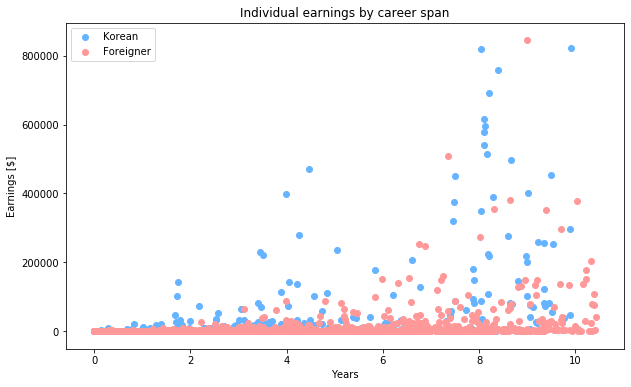

In [61]:
plt.figure(figsize = (10, 6))
plot_scatter_earnings(
    players_with_earnings, "career_years",
    title = "Individual earnings by career span", xlabel = "Years", show = False)
plt.legend()
plt.show()

This plot is more telling of earnings in the span of a professional player career. The highest earnings seem to be ones with long careers. There are of course high earnings with less experience, I can see around 6 players with earnings more than $200'000 within 3-5 year bracket (all South Korean by the way).

### Conclusion

As year pass history seems to repeate itself. But this is relevant to the industry in its entirety. There is a slow decline after the 10 mark with disruptions along the way with data seemingly to back it up.

It was informative to see how South Korean players had a major role the biggest e-Sport scenes. In fact, this notion can also be seen in the biggest of all League of Legends e-Sports scene but that would be a matter for another time.

## References

[1] Analysis by pstragowskipiotr: https://github.com/pstragowskipiotr/Starcraft-e-Sport-analysis

[2] Aligulac databases: http://aligulac.com/about/db/

[3] Article about overwatch: https://killscreen.com/themeta/pc-bangs-seoul-overwatch-reigns-supreme/

[4] Liquipedia for everything Starcraft related: https://liquipedia.net/

[5] Teamliquid official search engine for scraping data: https://tl.net/